In [80]:
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation
from keras.optimizers import SGD, Adam
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as k
import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
from IPython.display import clear_output
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator, array_to_img

import os
from tqdm import tqdm
import json

In [70]:
def CNN(input_shape, classes):
    activation_f = 'relu'
    input_img = Input(shape=input_shape)
    # layer 1
    x = Conv2D(32, (3,3), strides=1, activation='linear', padding='same')(input_img)
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation(activation_f)(x)
    x = Conv2D(32, (3,3), strides=1, activation='linear', padding='same')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation(activation_f)(x)
    x = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(x)
    #layer 2
    x = Conv2D(64, (3,3), strides=1, activation='linear', padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation(activation_f)(x)
    x = Conv2D(64, (3,3), strides=1, activation='linear', padding='same')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation(activation_f)(x)
    x = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(x)
    #x = Dropout(0.5)(x)
    #layer 3
    x = Conv2D(128, (3,3), strides=1, activation='linear', padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation(activation_f)(x)
    x = Conv2D(128, (3,3), strides=1, activation='linear', padding='same')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation(activation_f)(x)
    x = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(x)
    # fully-connected layer
    x = Flatten()(x)
    x = Dense(128, activation='linear')(x)
    x = Activation(activation_f)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dropout(0.5)(x)
    # softmax layer (output)
    pred = Dense(classes, activation='softmax')(x)
    
    model  = Model(input_img , pred)
    
    return model
    

In [56]:
def graph_training_history(history):
    acc_train = history['accuracy']
    acc_test = history['val_accuracy']
    loss_train = history['loss']
    loss_test = history['val_loss']
    #print(acc_train, acc_test, loss_train, loss_test)
    print(len(acc_train))
    plt.rcParams['axes.facecolor']='white'
    plt.figure(1)

    # summarize history for accuracy
    plt.subplot(121)
    plt.plot(acc_train)
    plt.plot(acc_test)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.tight_layout()

    # summarize history for loss
    plt.subplot(122)
    plt.plot(loss_train)
    plt.plot(loss_test)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.tight_layout()
    
    plt.show()

In [62]:
batch_size = 32

aug2=ImageDataGenerator(rescale=1./255, rotation_range=60, 
                    horizontal_flip=True, 
                    zoom_range=0.3)
       
aug = ImageDataGenerator(rescale=1./255)

train_folder = "/home/thimabru/Deep_Learning_aula/aula4/cyberlab_mission/UCMERCED_HW_SceneClassification/data/separated_in_labels/train"
test_folder = "/home/thimabru/Deep_Learning_aula/aula4/cyberlab_mission/UCMERCED_HW_SceneClassification/data/separated_in_labels/val"

In [57]:
input_shape = (150 , 150 , 3)
(w, h, _) = input_shape
print(w,h)
train_generator = aug2.flow_from_directory(train_folder, 
                                           target_size=(w, h),batch_size=batch_size, 
                                           class_mode='categorical', shuffle=True, seed=42)

test_generator = aug.flow_from_directory(test_folder,  
                                         target_size=(w, h),  batch_size=batch_size,  
                                         class_mode='categorical', shuffle=True, seed=42)

150 150
Found 1332 images belonging to 21 classes.
Found 342 images belonging to 21 classes.


In [67]:
file_name = 'best_model.h5'
checkpointer = ModelCheckpoint(file_name, monitor='val_acc', save_best_only=True)
early_stop = EarlyStopping(monitor = 'val_acc', min_delta = 0.001,
mode = 'max', patience = 5)
callbacks=[early_stop,checkpointer]

In [73]:
# Define shapes
classes = 21
epochs = 30
lr = 1e-4
batch_size = 64
epochs = 30
adam = Adam(learning_rate = lr)
net = CNN(input_shape, classes)
net.compile(loss = 'categorical_crossentropy', optimizer=adam , metrics=['accuracy'])
net.summary()

history = net.fit_generator(train_generator, steps_per_epoch=30, epochs=epochs, 
                              validation_data=test_generator,  validation_steps=1, 
                              verbose=1,callbacks=callbacks)


Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization_76 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
activation_75 (Activation)   (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_77 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
activation_76 (Activation)   (None, 150, 150, 32)      0  

Epoch 30/30
30/30 [==============================] - 13s 426ms/step - loss: 0.4108 - accuracy: 0.9093 - val_loss: 0.5388 - val_accuracy: 0.7727


30


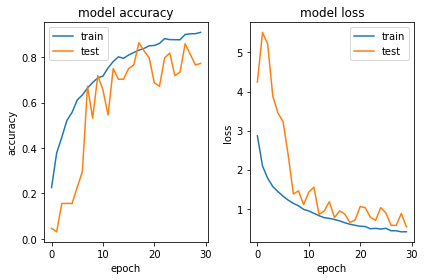

In [74]:
graph_training_history(history.history)

In [76]:
loss_ts = net.evaluate(x_test, y_test_h, verbose=1)
print("[Test loss: %f , Test acc.:%.2f%%] %(loss_ts[0] , 100 * loss_ts[1]")

NameError: name 'x_test' is not defined

In [82]:
net.save('model.h5')
# Saving history
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)